In [1]:
import sys
sys.path.append('..')
from gwtoolkit.gw import WaveformDataset
from gwtoolkit.torch import (WaveformDatasetTorch, Normalize_params, Patching_data, ToTensor)
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import itertools
import numpy

In [2]:
import bilby
bilby.__version__

'1.1.4: release'

In [3]:
import lalsimulation
lalsimulation.__version__

'3.0.0'

In [4]:
'\N{Rolling On The Floor Laughing}\N{Upside-Down Face}'

'🤣🙃'

# 1. Init for WaveformDataset

- parameters

In [5]:
# 1. Init for WaveformDataset
sampling_frequency = 4096     # [Hz], sampling rate
duration = 8                  # [sec], duration of a sample
conversion = 'BBH'
waveform_approximant = 'IMRPhenomPv2'
# waveform_approximant = 'SEOBNRv4P' ## TODO
# waveform_approximant = 'IMRPhenomPv2_NRTidal'
# waveform_approximant = 'IMRPhenomXP'
reference_frequency = 50.
minimum_frequency = 20.
waveform_arguments = dict(waveform_approximant=waveform_approximant,
                          reference_frequency=reference_frequency,
                          minimum_frequency=minimum_frequency)
base = 'bilby'
dets = ['H1', 'L1'][:1]

filename = '../tests/gw/demo.prior'   # default prior file

- Now init!

In [6]:
# waveform dataset
wfd = WaveformDataset(sampling_frequency=sampling_frequency,
                      duration=duration,
                      conversion=conversion)

wfd.load_prior_source_detector(
    filename=filename,
    base=base,
    dets=dets,
    waveform_arguments=waveform_arguments)

Using priors in ../tests/gw/demo.prior


# 2. Init for WaveformDatasetTorch

- parameters

In [7]:
# 2. Init for WaveformDatasetTorch
######### Hyper parameters start ###############################
patch_size = 0.5  # [sec]
overlap = 0.5     # [%]
num = 1000         # number of samples in an epoch.
target_time = 1126259456.3999023 + 6
buffer_time = 2
start_time = target_time-(duration - buffer_time)
geocent_time = (target_time-1.1, target_time+1.1)
SNR = 50          # 信噪比
# SNR = 0          # 使用 prior 中定义的 distance 来调整信噪比
target_optimal_snr_tuple = (0, SNR)
norm_params_kind = 'minmax'
norm_data_kind = 'standard'

stimulated_whiten_ornot = True   # Using stimulated whiten noise or not
classification_ornot = None
denoising_ornot = True           # For denoising
rand_transform_data = None
###

target_labels = ['mass_ratio', 'chirp_mass',                                  # mass dim
                 'luminosity_distance',                                       # SNR related
                 'dec', 'ra', 'theta_jn', 'psi', 'phase',                     # oritation related
                 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl',        # spin related
                 'geocent_time',                                              # arrival time related
                 'optimal_snr', 'matched_filter_snr'
                ]
######### Hyper parameters end ###############################
from torchvision.transforms import Normalize

composed_data = transforms.Compose([
    Patching_data(patch_size=patch_size,
                  overlap=overlap,
                  sampling_frequency=sampling_frequency),
    # input:  (batch_size, 2               ,   duration * sampling_rate)
    # output: (batch_size, 2 * num_of_patch, patch_size * sampling_rate)    
    ToTensor(),
    Normalize(mean=(0,)*num, std=(45.6,)*num),  # specify ~45.6 for std=1
])
composed_params = None if denoising_ornot else transforms.Compose([
    Normalize_params(norm_params_kind,
                     wfd=wfd, labels=target_labels,
                     feature_range=(-1, 1)),
    ToTensor(),
])

	Patching with patch size=0.5s and overlap=50.0%.


- Now init!

In [8]:
# waveform dataset using Torch, "wfdt"
wfdt = WaveformDatasetTorch(wfd, num=num,
                            start_time=start_time,
                            geocent_time=geocent_time,
                            target_optimal_snr_tuple=target_optimal_snr_tuple,
                            target_labels=target_labels,
                            stimulated_whiten_ornot=stimulated_whiten_ornot,
                            transform_data=composed_data,
                            transform_params=composed_params,
                            rand_transform_data=rand_transform_data,
                            classification_ornot=classification_ornot,
                            denoising_ornot=denoising_ornot)

100%|████████████████████████████████████████████████████| 1000/1000 [00:32<00:00, 31.10it/s]


In [23]:
import ray
from tqdm import tqdm
import time

# Start Ray. If you're connecting to an existing cluster, you would use
# ray.init(address=<cluster-address>) instead.
ray.shutdown()
ray.init()

# A regular Python function.
def my_function():
    return 1

# By adding the `@ray.remote` decorator, a regular Python function
# becomes a Ray remote function.
@ray.remote
def my_function():
    return 1

# To invoke this remote function, use the `remote` method.
# This will immediately return an object ref (a future) and then create
# a task that will be executed on a worker process.
obj_ref = my_function.remote()

# The result can be retrieved with ``ray.get``.
assert ray.get(obj_ref) == 1

@ray.remote
def slow_function():
    time.sleep(10)
    print(1)
    return 1

2021-12-09 17:05:03,688	INFO services.py:1338 -- View the Ray dashboard at http://127.0.0.1:8266
2021-12-09 17:05:03,695	WARNING services.py:1816 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 66768896 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=10.24gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.


In [6]:
import time
import random
import ray
import numpy as np
from tqdm import tqdm


ray.shutdown()
ray.init(num_cpus = 4)

2021-12-09 17:21:40,112	INFO services.py:1338 -- View the Ray dashboard at http://127.0.0.1:8266
2021-12-09 17:21:40,119	WARNING services.py:1816 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 66699264 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=10.24gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.


{'node_ip_address': '172.17.0.4',
 'raylet_ip_address': '172.17.0.4',
 'redis_address': '172.17.0.4:58024',
 'object_store_address': '/tmp/ray/session_2021-12-09_17-21-37_683161_77378/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-12-09_17-21-37_683161_77378/sockets/raylet',
 'webui_url': '127.0.0.1:8266',
 'session_dir': '/tmp/ray/session_2021-12-09_17-21-37_683161_77378',
 'metrics_export_port': 64862,
 'node_id': 'fcba2b9809a50b1fc47f0ec5c55e1579a35b259b277fea6079dcbd69'}

In [ ]:
@ray.remote
def do_some_work(x):
    time.sleep(random.uniform(0, 4)) # Replace this with work you need to do.
    return x

def process_results(results):
    sum = 0
    for x in results:
        
        sum += x
    return sum

start = time.time()
data_list = ray.get([do_some_work.remote(x) for x in range(4)])
sum = process_results(data_list)
print("duration =", time.time() - start, "\nresult = ", sum)

In [8]:
num = 1000
block = np.empty(shape=(num, 2, 4096), dtype=np.float64)

for i in tqdm(range(num)):
    time.sleep(0.002)
    for j in range(2):
        time.sleep(0.002)
        block[i, j] = np.random.randn(4096)

100%|███████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.01it/s]


In [35]:
num = 1000
block = np.empty(shape=(num, 2, 4096), dtype=np.float64)

def inside_func(i, block):
    time.sleep(0.002)
    for j in range(2):
        time.sleep(0.002)
        block[i, j] = np.random.randn(4096)
[inside_func(i, block) for i in tqdm(range(num))];

100%|███████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.49it/s]


In [36]:
block.shape

(1000, 2, 4096)

In [ ]:
ray.shutdown()
ray.init(num_cpus = 4)

num = 1000
block = np.empty(shape=(num, 2, 4096), dtype=np.float64)

@ray.remote
def inside_func(i, block):
    time.sleep(0.002)
    np.append(np.empty((0,2, 4096), int), np.random.randn(2, 4096), axis=0)

start = time.time()
result = ray.get(([inside_func.remote(i, block) for i in range(num)]))

print("duration =", time.time() - start)

In [37]:
block

array([[[-0.05335406,  0.03806074, -1.28224174, ...,  1.23772256,
          0.65159577,  0.16936774],
        [ 1.08247536, -0.61582219,  0.38185589, ..., -2.36134382,
          0.46962224, -2.15812491]],

       [[-0.65985742, -1.947648  , -2.28145315, ...,  0.48927545,
         -2.36480997,  0.40030177],
        [-0.1150723 ,  2.31446514,  0.58706427, ..., -2.57938867,
         -0.70939043, -0.27618342]],

       [[ 1.08308974,  0.19314782,  0.76560538, ...,  1.01313128,
         -0.34083962, -1.53526314],
        [-0.28098317,  1.10670253, -0.14936795, ..., -0.13245056,
          1.28858673, -0.21224291]],

       ...,

       [[ 0.2242351 , -0.22506276, -0.01896189, ..., -0.27674568,
          0.68480922, -0.28445765],
        [-1.12531666,  0.08242137,  0.20037792, ..., -1.46184965,
         -1.4879289 , -1.35870723]],

       [[ 0.39384955, -0.24977294,  1.13171258, ..., -1.76132925,
          0.99323454,  2.06818184],
        [-0.80304177, -0.6542905 ,  1.00089324, ..., -0.07816

In [23]:
np.concatenate(result).shape

(2000, 4096)

# 3. DataLoader objects

- parameters

In [9]:
batch_size = 8
shuffle = False

- Now init!

In [10]:
# DataLoader objects
loader = DataLoader(wfdt, batch_size=batch_size, shuffle=shuffle, pin_memory=False,
                    num_workers=0, worker_init_fn=lambda _: numpy.random.seed(
                        int(torch.initial_seed()) % (2**32-1)))

# How to do the iteration

In [11]:
# wfd.dets['H1'].ifo.power_spectral_density(psd_file=)
wfdt.update()  # dynamic update our prior in loader.
for index, (data, signal, noise, param) in enumerate(loader):
    break
data.shape, signal.shape, noise.shape, param.shape

100%|██████████████████████████████████████████████████████| 1000/1000 [00:29<00:00, 33.65it/s]


(torch.Size([8, 31, 2048]),
 torch.Size([8, 31, 2048]),
 torch.Size([8, 31, 2048]),
 torch.Size([8, 17]))

In [12]:
# 可以查看每个样本的物理参数，包括信噪比
import pandas as pd
pd.DataFrame(param.numpy(), columns=wfdt.var.target_labels)
# pd.DataFrame(wfdt.transform_inv_params(param), columns=wfdt.var.target_labels)

,mass_ratio,chirp_mass,luminosity_distance,dec,ra,theta_jn,psi,phase,a_1,a_2,tilt_1,tilt_2,phi_12,phi_jl,geocent_time,optimal_snr,matched_filter_snr
0,0.560256+0.000000j,29.394386+0.000000j,315.437147+0.000000j,-0.625337+0.000000j,0.419239+0.000000j,1.572314+0.000000j,2.766147+0.000000j,4.615092+0.000000j,0.612523+0.000000j,0.310221+0.000000j,2.740754+0.000000j,1.547895+0.000000j,3.273305+0.000000j,2.469741+0.000000j,1.126259e+09+0.000000e+00j,50.0+0.0j,51.467113-1.738165j
1,0.757691+0.000000j,31.273648+0.000000j,242.712127+0.000000j,-0.695332+0.000000j,4.287012+0.000000j,2.061038+0.000000j,0.390522+0.000000j,4.270562+0.000000j,0.426803+0.000000j,0.735144+0.000000j,1.662740+0.000000j,0.962472+0.000000j,5.371554+0.000000j,2.871985+0.000000j,1.126259e+09+0.000000e+00j,50.0+0.0j,49.008560+1.274019j
2,0.716413+0.000000j,26.299200+0.000000j,495.839891+0.000000j,0.678531+0.000000j,1.849816+0.000000j,1.684786+0.000000j,1.879950+0.000000j,0.748761+0.000000j,0.793137+0.000000j,0.789543+0.000000j,2.116109+0.000000j,0.743664+0.000000j,3.690504+0.000000j,4.684152+0.000000j,1.126259e+09+0.000000e+00j,50.0+0.0j,52.595573-0.319488j
3,0.919304+0.000000j,26.691826+0.000000j,522.256573+0.000000j,0.222791+0.000000j,5.424080+0.000000j,2.140209+0.000000j,1.105298+0.000000j,6.192013+0.000000j,0.009983+0.000000j,0.802241+0.000000j,1.847191+0.000000j,0.943544+0.000000j,1.223408+0.000000j,3.007098+0.000000j,1.126259e+09+0.000000e+00j,50.0+0.0j,50.457466+0.915763j
4,0.982526+0.000000j,28.969946+0.000000j,502.730007+0.000000j,-1.150835+0.000000j,1.889768+0.000000j,2.903649+0.000000j,1.070716+0.000000j,4.926610+0.000000j,0.320686+0.000000j,0.623666+0.000000j,2.394412+0.000000j,1.963232+0.000000j,5.698473+0.000000j,4.598427+0.000000j,1.126259e+09+0.000000e+00j,50.0+0.0j,48.368488+1.164423j
5,0.902224+0.000000j,34.619533+0.000000j,453.466198+0.000000j,0.145041+0.000000j,3.941401+0.000000j,1.474211+0.000000j,0.424088+0.000000j,1.975412+0.000000j,0.989435+0.000000j,0.251507+0.000000j,0.916223+0.000000j,2.730953+0.000000j,4.430123+0.000000j,0.902090+0.000000j,1.126259e+09+0.000000e+00j,50.0+0.0j,48.984627-0.163030j
6,0.982184+0.000000j,28.228650+0.000000j,620.499241+0.000000j,1.166994+0.000000j,4.592052+0.000000j,1.449147+0.000000j,2.277511+0.000000j,4.761784+0.000000j,0.083500+0.000000j,0.865216+0.000000j,0.325253+0.000000j,2.238220+0.000000j,1.545089+0.000000j,2.500244+0.000000j,1.126259e+09+0.000000e+00j,50.0+0.0j,49.760738+0.681897j
7,0.907950+0.000000j,33.718764+0.000000j,657.589122+0.000000j,-0.268543+0.000000j,1.205327+0.000000j,0.796850+0.000000j,1.642818+0.000000j,4.016241+0.000000j,0.627352+0.000000j,0.590766+0.000000j,0.781782+0.000000j,1.754623+0.000000j,3.187384+0.000000j,1.440969+0.000000j,1.126259e+09+0.000000e+00j,50.0+0.0j,49.619637-0.541059j


/root/miniconda3/envs/gwtoolkit/lib/python3.8/site-packages/pandas/core/construction.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  subarr = np.array(arr, dtype=dtype, copy=copy)


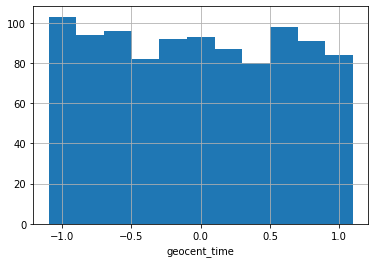

In [14]:
import matplotlib.pyplot as plt
# 查看一个 epoch 所有信号的到达时间在 target_time 周围的分布
pd.DataFrame(wfdt.params_block, columns=wfdt.var.target_labels, dtype=float)['geocent_time'].map(lambda x: x-target_time).hist(bins='auto');
plt.xlabel('geocent_time');

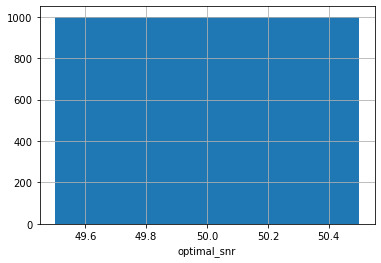

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(wfdt.params_block, columns=wfdt.var.target_labels, dtype=float)['optimal_snr'].hist(bins='auto');
plt.xlabel('optimal_snr');
# plt.xscale('log');

In [16]:
# 可以看到数据已经被标准化了
data.mean(), data.std()

(tensor(1.4361e-05, dtype=torch.float64), tensor(1.0263, dtype=torch.float64))

In [17]:
# 验证：数据 = 信号 + 噪声
numpy.allclose( data.numpy() ,signal.numpy()+noise.numpy() )

True

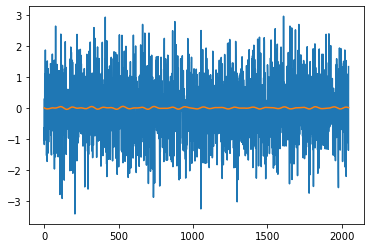

In [18]:
# 因为是数据都是被 patching 化了，所以信号截断出现在部分的 token 维度上
# (only works on fixed SNR dataset)
import matplotlib.pyplot as plt
plt.plot(data.numpy()[0,23])
plt.plot(signal.numpy()[0,23])

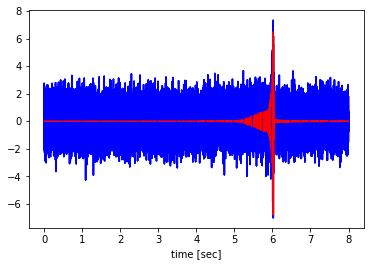

In [19]:
# 将 patch 化的数据重新组合起来，观察训练的第 index 信号:
import matplotlib.pyplot as plt
index = 2
patch_size_sec = int(patch_size * sampling_frequency)
for i in range(signal.shape[1]):
    plt.plot(numpy.linspace(0+patch_size*overlap*i, patch_size*(overlap*i+1), 
                            num=patch_size_sec), 
             data[index][i].numpy(), color='b')    
    plt.plot(numpy.linspace(0+patch_size*overlap*i, patch_size*(overlap*i+1), 
                            num=patch_size_sec), 
             signal[index][i].numpy(), color='r')
plt.xlabel('time [sec]');